In [1]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, MLSolver

Precompiling packages...
  12331.9 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 15 seconds. 496 already precompiled.


In [2]:
using CairoMakie, ProgressLogging
using Base.Threads
using BenchmarkTools
using JLD2, Geppetto

In [3]:
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# ODE/PDE Solving

## Basic no space solve

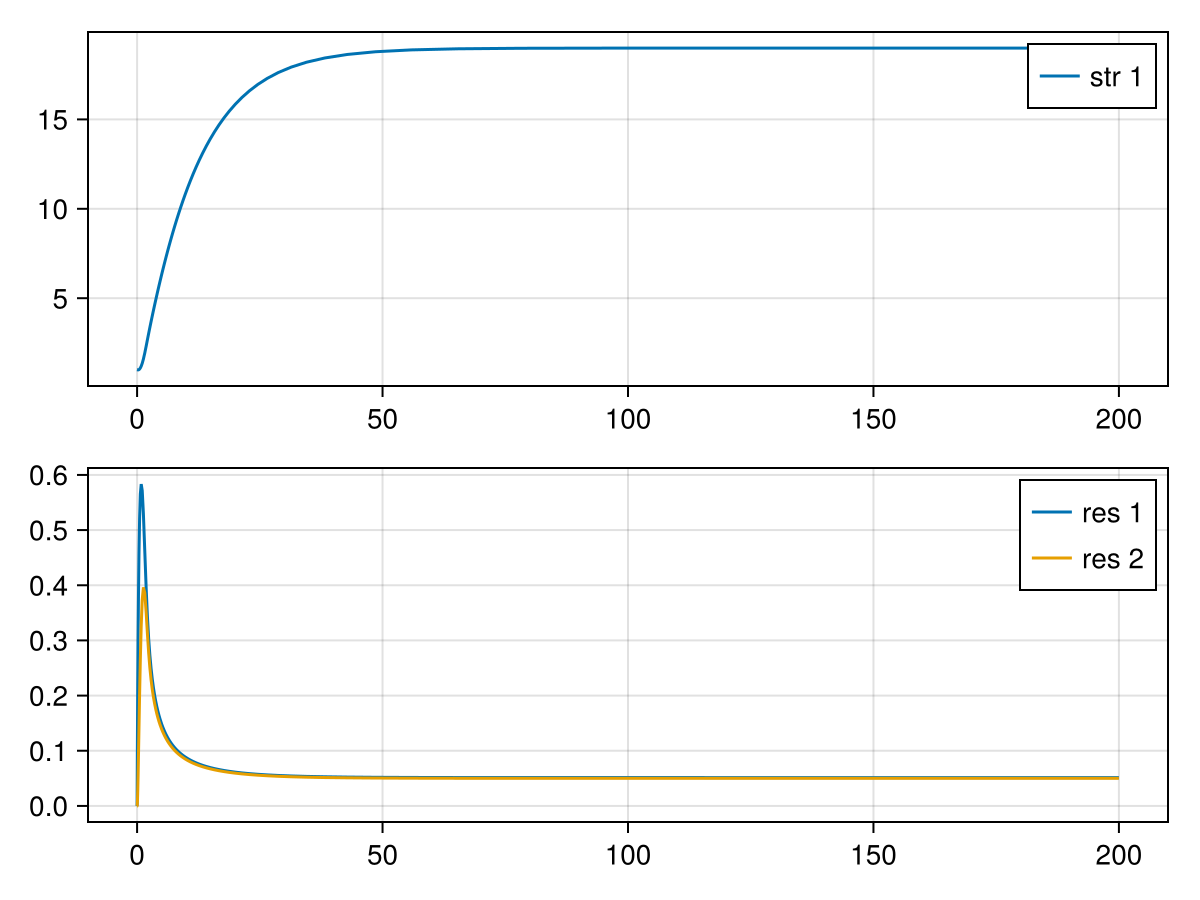

3-element Vector{Float64}:
 18.986817201996566
  0.05131674360473515
  0.05000003961685623

In [7]:
D = fill(0., 1, 2, 2)
D[1, 2, 1] = 1.
c = [2. 2.]
l = [1. 0.]

params = make_sammicrmparams(1, 2;
    D, c, l,
    K=[2., 0.],
    r=[1., 1.],
    m=[0.1],
)
u0 = make_u0_smart(params;
    u0=:onlyN,
    u0rand=0.
)

p = make_mmicrm_problem(params, u0, 200)
s = solve(p)
check_mmicrmparams(p.p)
display(plot_mmicrm_sol(s))
s.u[end]
#param_summary(p.p)

In [8]:
solve(SteadyStateProblem(p), DynamicSS())

retcode: Success
u: 3-element Vector{Float64}:
 18.98666214934115
  0.05131715292462866
  0.050000428909981756

## Spatial stuff

In [24]:
Ds = SA[1e-5, 500, 0.1]
usol = s.u[end]

show(uninplace(mmicrmfunc!)(usol, p.p, 0))

[1.5043960145658643e-6, -4.054400148945092e-9, -3.762862466061279e-9]

### Linear stability analysis

mrl = 0.001883153838108191


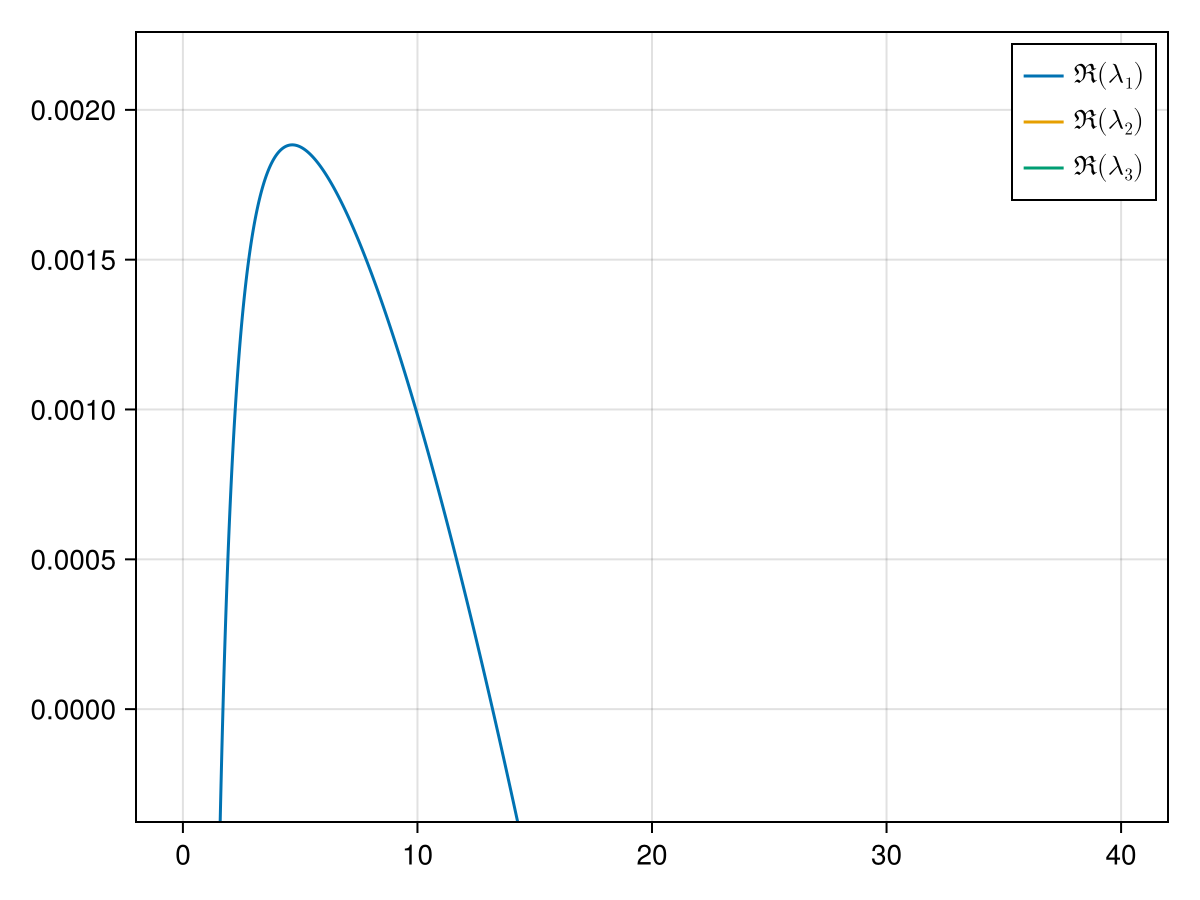

In [21]:
ks = LinRange(0., 40., 10000)

lambda_func = linstab_make_k_func(params, Ds, usol)
full_linstab_func = linstab_make_k_func(params, Ds, usol; returnobj=:full)

lambdas = lambda_func.(ks)
mrl = maximum(x->maximum(real,x), lambdas)
@show mrl

faa = plot_linstab_lambdas(ks, lambdas)
ylims!(faa.axis, (- 0.2 * mrl, 1.2 * mrl))
# xlims!(faa.axis, (0., 2.))
faa

In [22]:
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
@show kmax
flmax = full_linstab_func(kmax)
flmax.vectors[:,1]

kmax = 4.664466446644664


3-element Vector{Float64}:
 -0.999999998425741
  9.400737817253314e-6
 -5.5318567907767844e-5

### Spatial stuff - 1D!

In [25]:
ssize = (1000,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform_prop(get_Ns(p.p)..., su0, 0.1, 0.1)

space = make_cartesianspace_smart(length(ssize); dx=0.01, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing

sparams = SASMMiCRMParams(params, Ds, space, usenthreads)
sp = make_smmicrm_problem(sparams, psu0, 10000000)

size(sp.u0), sp.p.usenthreads, sp.p.space

((3, 1000), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([0.01]))

#### Direct solver

In [26]:
@time sps = solve(sp, QNDF(); maxiters=1000)
print_spatial_solution_stats(sps)

  6.311513 seconds (16.61 M allocations: 1.438 GiB, 3.64% gc time, 166.77% compilation time)
Success
nf is 1762
solution has 327 saved states
max resid is 1.30426e-06


┌ Warning: reaching negative values, minimum is -1.43513e-05
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


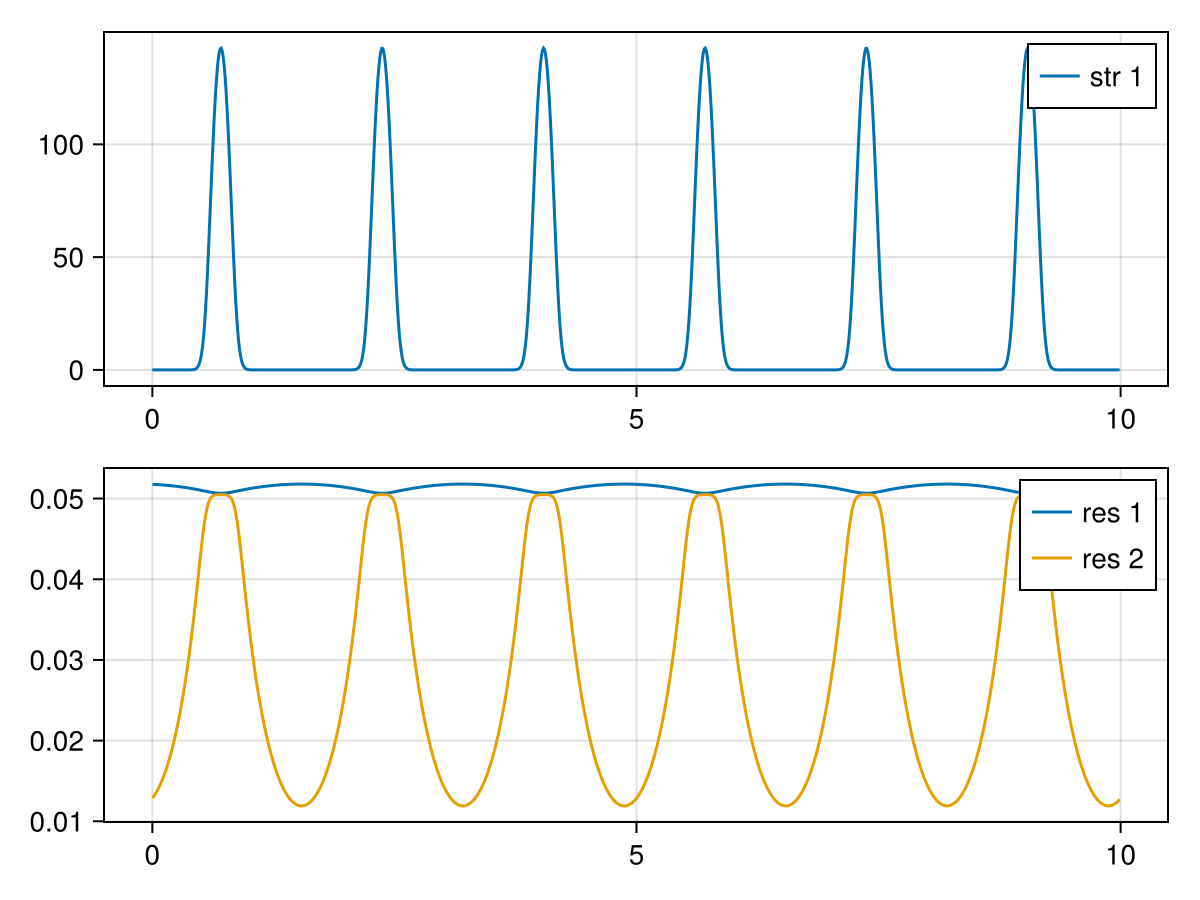

In [27]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps(sps.t[end]))

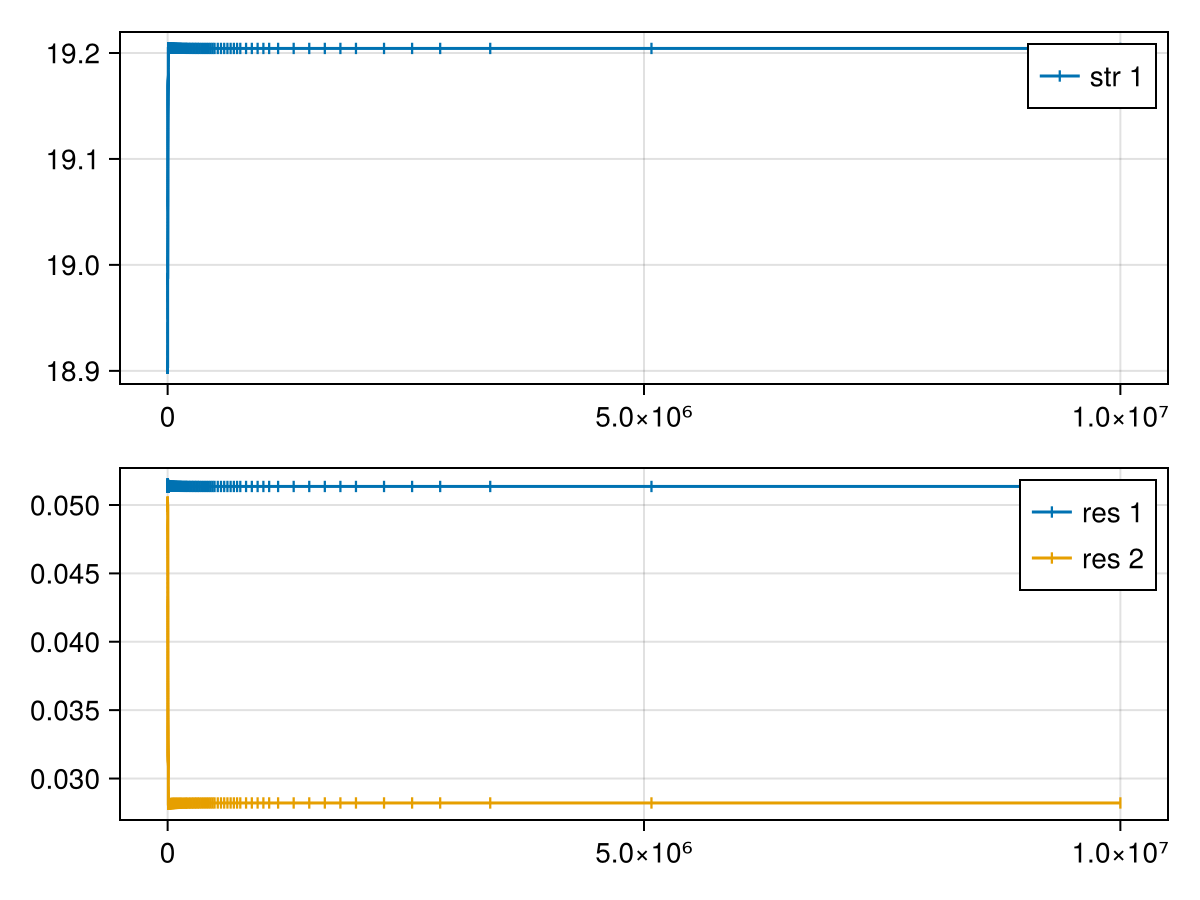

In [28]:
plot_smmicrm_sol_avgs(sps)

### Spatial stuff - 2D!

In [29]:
ssize = (60,60)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)

space = make_cartesianspace_smart(length(ssize); dx=0.1, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing

sparams = SASMMiCRMParams(params, Ds, space, usenthreads)
sp = make_smmicrm_problem(sparams, psu0, 10000000)

size(sp.u0), sp.p.usenthreads, sp.p.space

((3, 60, 60), 18, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.1, 0.1]))

#### Direct solver

In [30]:
@time sps = solve(sp, QNDF(); maxiters=10000)
print_spatial_solution_stats(sps)

 32.325605 seconds (9.11 M allocations: 7.738 GiB, 2.04% gc time, 34.54% compilation time)
Success
nf is 4292
solution has 532 saved states
max resid is 1.73256e-08


┌ Warning: reaching negative values, minimum is -0.0499727
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


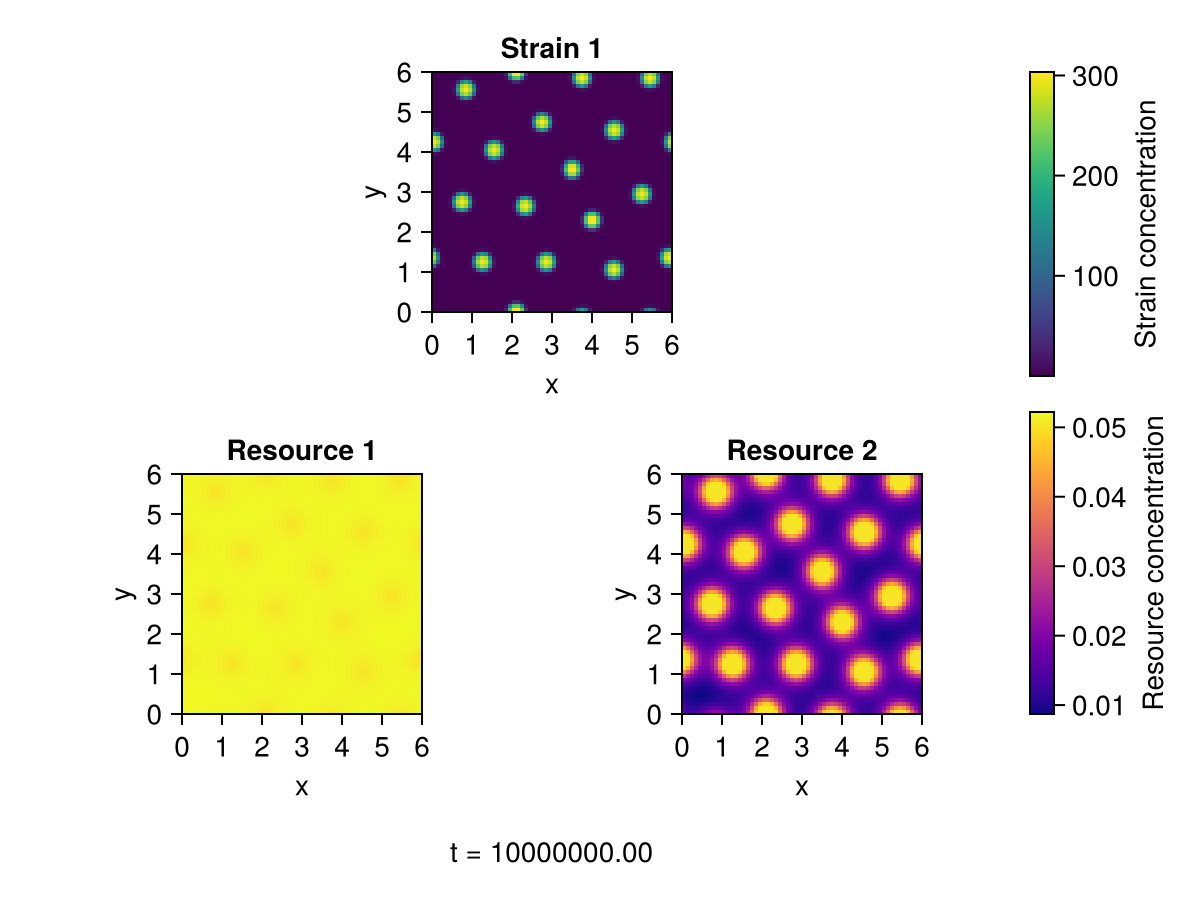

In [31]:
f = plot_2dsmmicrm_sol_snap_heatmap(sps, -1)

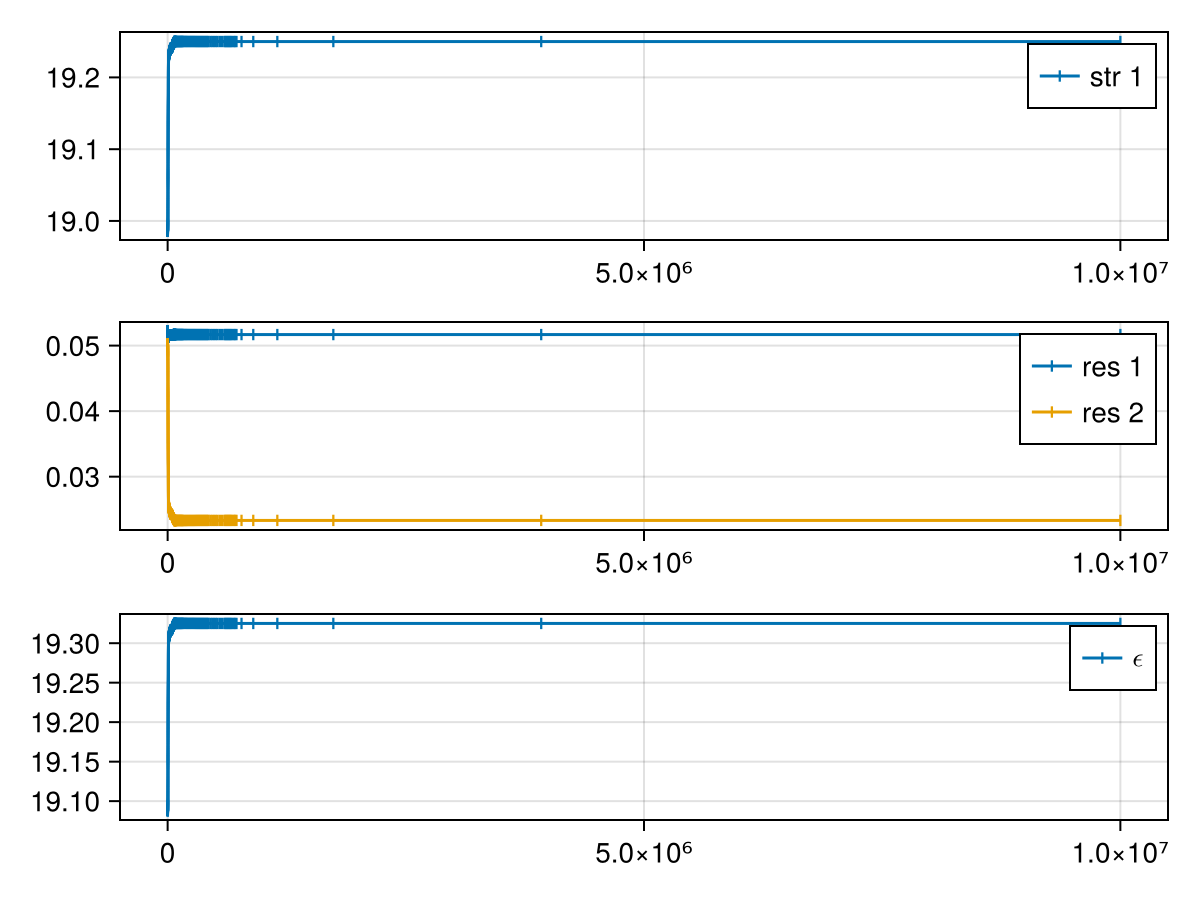

In [32]:
f = plot_smmicrm_sol_avgs(sps; plote=true)
# display(GLMakie.Screen(), f)
f

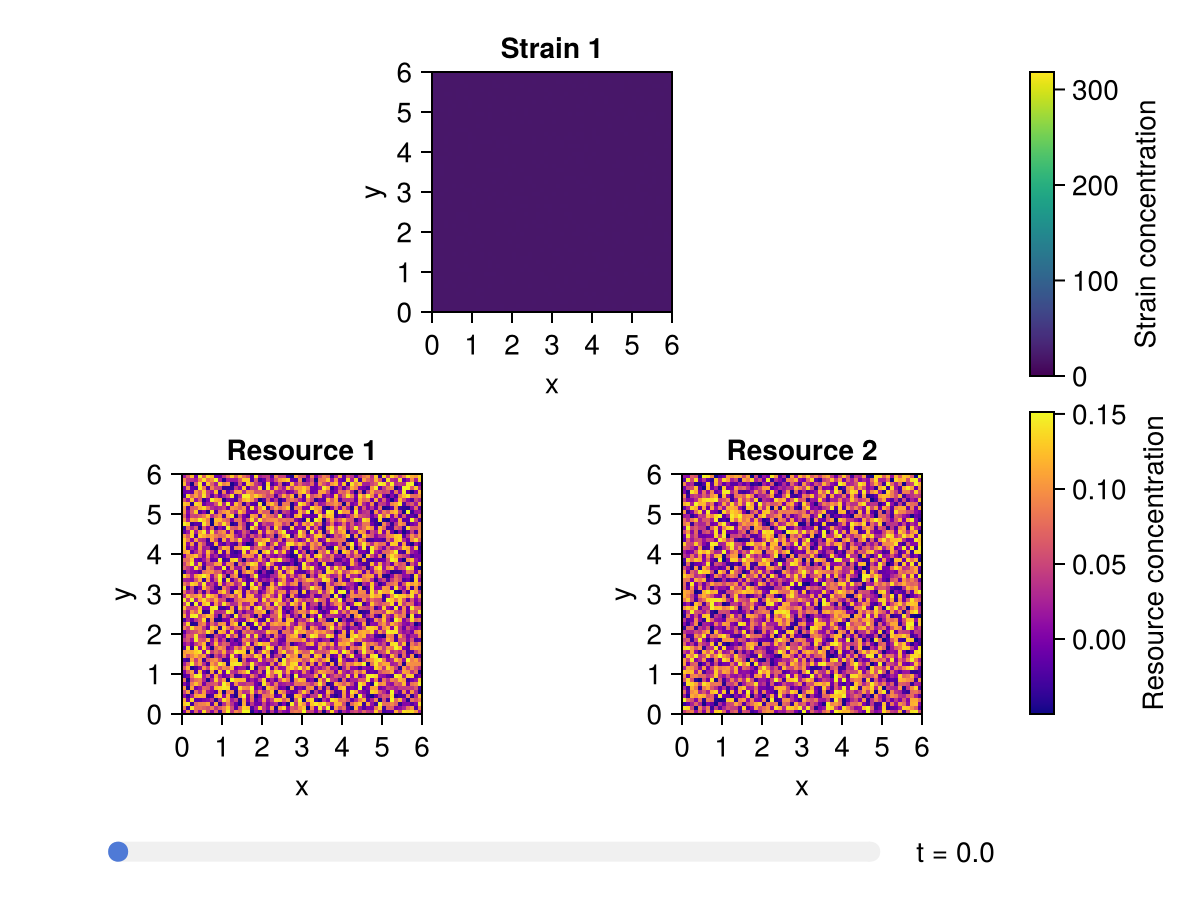

In [35]:
f = plot_2dsmmicrm_sol_interactive_heatmap(sps)
# display(GLMakie.Screen(), f)
f

### Saving/loading

In [61]:
save_object(datadir("minimalmodel", randname()*".jld2"), sps)

In [9]:
sps = load_object("../data/minimalmodel/fascinating_maybe_moving.jld2");
print_spatial_solution_stats(sps)

MaxIters
nf is 110126
solution has 8608 saved states
max resid is 0.00431203


# Symbolics

In [36]:
using Symbolics, SymbolicsMathLink
import Nemo


Welcome to Nemo version 0.48.4

Nemo comes with absolutely no warranty whatsoever


In [37]:
function mycoeff(exp, var, power)
    s = Num(0)
    for t in Symbolics.terms(exp)
        if Symbolics.degree(t, var) == power
            s += t / (var^power)
        end
    end
    s
    # sum(filter(t->Symbolics.degree(t, var)==power, Symbolics.terms(exp)))
end

mycoeff (generic function with 1 method)

In [38]:
pvars = @variables m l K c d
fvars = @variables N G R
ssvars = @variables N_ss G_ss R_ss
Dvars = @variables D_N D_G D_R
@variables k;

In [40]:
sym_params = SAMMiCRMParams(
    Num.(p.p.g), Num.(p.p.w),
    SA[m],
    SA[K, 0.], Num.(SA[1., 1.]),
    SA[l 0.], SA[c d], Num.(p.p.D)
)
u = SA[N, G, R]
eqs = uninplace(mmicrmfunc!)(u, sym_params)

3-element SizedVector{3, Num, Vector{Num}} with indices SOneTo(3):
 (-m + R*d + G*c*(1.0 - l))*N
               -G + K - G*N*c
         -R - N*R*d + G*N*c*l

#### Analytic expressions for mixed (no space) steady states and their stability

express G and R in terms of N and then get a quadratic equation in N **ONLY VALID IF N IS NOT 0**

In [41]:
mR = symbolic_solve((eqs[1]/N)~0, R)[1]
mG = symbolic_solve(eqs[2]~0, G)[1]
display(R==mR)
display(G==mG)
feq = simplify(substitute(substitute(eqs[3], R=>mR), G=>mG)*(-d*(1+N*c)))
display(feq==0)

R == ((-m + G*c - G*c*l) / (-d))

G == (K / (1 + N*c))

(m - K*c + K*c*l + N*c*m + N*d*m - K*N*c*d + (N^2)*c*d*m) == 0

##### alternate expression for R that is valid even when N is 0, aka N=0 => R=0

In [42]:
mR2 = symbolic_solve(eqs[3]~0, R)[1]
display(Symbolics.variable(:R_v2)==mR2)

R_v2 == ((G*N*c*l) / (1 + N*d))

##### Interpretable solution?

In [43]:
c, b, a = mycoeff.(feq, N, 0:2)
display([a, b, c])
D = b^2 - 4*a*c

3-element Vector{Num}:
             c*d*m
 c*m + d*m - K*c*d
   m - K*c + K*c*l

(c*m + d*m - K*c*d)^2 - 4(m - K*c + K*c*l)*c*d*m

In [44]:
display(expand(D))
display(wcall("Simplify", wcall("Expand", D)))
display(wcall("FullSimplify", wcall("Expand", D)))
display(wcall("FullSimplify", D))
sD = wcall("FullSimplify", D);

(c^2)*(m^2) - (2//1)*c*d*(m^2) + (d^2)*(m^2) + (2//1)*K*(c^2)*d*m - (2//1)*K*c*(d^2)*m + (K^2)*(c^2)*(d^2) - (4//1)*K*(c^2)*d*l*m

(d^2)*(m^2) - 2(m + K*d)*c*d*m + (m^2 + (K^2)*(d^2) + 2K*d*(1 - 2l)*m)*(c^2)

((c - d)^2)*(m^2) + (K^2)*(c^2)*(d^2) - 2K*c*(d + c*(-1 + 2l))*d*m

((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m

In [46]:
N1 = simplify((-b+sqrt(sD))/(2*a))

(sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m - d*m + K*c*d) / (2c*d*m)

In [47]:
show(latexstring(N1))

L"$(sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m - d*m + K*c*d) / (2c*d*m)$"

##### Naively plugging this into forms for M1 and M (kinda pointless)

In [25]:
G1 = simplify(Num(substitute(mG, N=>N1)))
R1 = simplify(Num(substitute(mR, G=>G1)))
mssol1 = [N1, G1, R1]

3-element Vector{Num}:
                                                                                                            (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m - d*m + K*c*d) / (2c*d*m)
                                                                                                            (2K*d*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d)
 (-m*sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) + c*(m^2) - d*(m^2) + K*c*d*m - (2//1)*K*c*d*l*m) / ((-sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) + c*m - d*m - K*c*d)*d)

In [236]:
make_M1(sym_params, mssol1)

3×3 Matrix{Num}:
 -m + (-m*sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) + c*(m^2) - d*(m^2) + K*c*d*m - (2//1)*K*c*d*l*m) / (-sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) + c*m - d*m - K*c*d) + (2K*c*d*(1 - l)*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d)  …          (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m - d*m + K*c*d) / (2c*m)
                                                                                                                                                                                                              -((2K*c*d*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d))                                                                                                 0.0
             (2K*c*d*l*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d) + (m*sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*(m^2) + 

In [26]:
make_M1(sym_params, mssol1)

3×3 Matrix{Num}:
 -m + (-m*sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) + c*(m^2) - d*(m^2) + K*c*d*m - (2//1)*K*c*d*l*m) / (-sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) + c*m - d*m - K*c*d) + (2K*c*d*(1 - l)*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d)  …          (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m - d*m + K*c*d) / (2c*m)
                                                                                                                                                                                                              -((2K*c*d*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d))                                                                                                 0.0
             (2K*c*d*l*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d) + (m*sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*(m^2) + 

#### Ms with general/symbolic ss sol

In [48]:
symM1 = make_M1(sym_params, ssvars)

3×3 Matrix{Num}:
 -m + R_ss*d + G_ss*c*(1 - l)  N_ss*c*(1 - l)         N_ss*d
                      -G_ss*c   -1.0 - N_ss*c            0.0
           -R_ss*d + G_ss*c*l        N_ss*c*l  -1.0 - N_ss*d

In [48]:
export_expr_to_wolfram(symM1, datadir("minimalmodel", "ssymM1"))

In [51]:
symM = M1_to_M(symM1, Dvars, k)

3×3 Matrix{Num}:
 -m + R_ss*d - D_N*(k^2) + G_ss*c*(1 - l)  …                     N_ss*d
                                  -G_ss*c                           0.0
                       -R_ss*d + G_ss*c*l     -1.0 - N_ss*d - D_R*(k^2)

In [199]:
export_expr_to_wolfram(symM, datadir(randname()))

#### Ms for the trivial extinct solution

In [52]:
triv_M1 = make_M1(sym_params, [0, K, 0])

3×3 Matrix{Num}:
 -m + K*c*(1 - l)     0     0
             -K*c  -1.0   0.0
            K*c*l   0.0  -1.0

In [54]:
M1_to_M(triv_M1, Dvars, k)

3×3 Matrix{Num}:
 -m - D_N*(k^2) + K*c*(1 - l)                 0                 0
                         -K*c  -1.0 - D_G*(k^2)               0.0
                        K*c*l               0.0  -1.0 - D_R*(k^2)

#### Ms for the non-extinct solution where we keep only N_ss symbolic

In [33]:
mGss = substitute(mG, N=>ssvars[1])
mRss = substitute(mR2, [G=>mGss, N=>ssvars[1]])
display(mGss)
display(mRss)

K / (1 + N_ss*c)

(K*N_ss*c*l) / ((1 + N_ss*c)*(1 + N_ss*d))

In [45]:
simplify(make_M1(sym_params, [ssvars[1], mGss, mRss]))

3×3 Matrix{Num}:
 -m + (K*c*(1 - l)) / (1 + N_ss*c) + (K*N_ss*c*d*l) / ((1 + N_ss*c)*(1 + N_ss*d))  …  N_ss*c*(1 - l)         N_ss*d
                                                          -((K*c) / (1 + N_ss*c))      -1.0 - N_ss*c            0.0
           (K*c*l) / (1 + N_ss*c) + (-K*N_ss*c*d*l) / ((1 + N_ss*c)*(1 + N_ss*d))           N_ss*c*l  -1.0 - N_ss*d

#### More bits

##### Making the K polynomial

In [325]:
@variables a b c d e f g h i o p q K;
M = [a - o*K b c; d e - p*K f; g h i - q*K]
display(M)
detM = det(M)
edetM = expand(detM)

3×3 Matrix{Num}:
 a - K*o        b        c
       d  e - K*p        f
       g        h  i - K*q

a*e*i - a*f*h - b*d*i + b*f*g + c*d*h - c*e*g - K*a*e*q - K*a*i*p + K*b*d*q + K*c*g*p - K*e*i*o + K*f*h*o + (K^2)*a*p*q + (K^2)*e*o*q + (K^2)*i*o*p - (K^3)*o*p*q

In [326]:
Kcoeffs = mycoeff.(edetM, K, 0:3)

4-element Vector{Num}:
  a*e*i - a*f*h - b*d*i + b*f*g + c*d*h - c*e*g
 -a*e*q - a*i*p + b*d*q + c*g*p - e*i*o + f*h*o
                          a*p*q + e*o*q + i*o*p
                                         -o*p*q

In [327]:
simplify(expand(sum(Kcoeffs .* K.^(0:3))) == edetM)

true

In [328]:
string.(Kcoeffs)

4-element Vector{String}:
 "a*e*i - a*f*h - b*d*i + b*f*g + c*d*h - c*e*g"
 "-a*e*q - a*i*p + b*d*q + c*g*p - e*i*o + f*h*o"
 "a*p*q + e*o*q + i*o*p"
 "-o*p*q"

In [329]:
@variables a b c d e f g h i o p q K l;
fM = [a - o*K - l b c; d e - p*K - l f; g h i - q*K - l]
display(fM)
detfM = det(fM)
# simplify(detfM)
edetfM = expand(detfM)

3×3 Matrix{Num}:
 a - l - K*o            b            c
           d  e - l - K*p            f
           g            h  i - l - K*q

a*e*i - a*e*l - a*f*h - a*i*l + a*(l^2) - b*d*i + b*d*l + b*f*g + c*d*h - c*e*g + c*g*l - e*i*l + e*(l^2) + f*h*l + i*(l^2) - (l^3) - K*a*e*q - K*a*i*p + K*a*l*p + K*a*l*q + K*b*d*q + K*c*g*p - K*e*i*o + K*e*l*o + K*e*l*q + K*f*h*o + K*i*l*o + K*i*l*p - K*(l^2)*o - K*(l^2)*p - K*(l^2)*q + (K^2)*a*p*q + (K^2)*e*o*q + (K^2)*i*o*p - (K^2)*l*o*p - (K^2)*l*o*q - (K^2)*l*p*q - (K^3)*o*p*q

In [324]:
mycoeff.(edetfM, l, 0:3)

4-element Vector{Num}:
 a*e*i - a*f*h - b*d*i + b*f*g + c*d*h - c*e*g - K*a*e*q - K*a*i*p + K*b*d*q + K*c*g*p - K*e*i*o + K*f*h*o + (K^2)*a*p*q + (K^2)*e*o*q + (K^2)*i*o*p - (K^3)*o*p*q
                                            -a*e - a*i + b*d + c*g - e*i + f*h + K*a*p + K*a*q + K*e*o + K*e*q + K*i*o + K*i*p - (K^2)*o*p - (K^2)*o*q - (K^2)*p*q
                                                                                                                                       a + e + i - K*o - K*p - K*q
                                                                                                                                                                -1

# Extras

In [952]:
GC.gc()
empty!(Out)

Dict{Int64, Any}()